### Adjuration

There really does not seem to this author to be a fast path to using `xarray`. At some point the novice must
set aside other concerns and just spend time methodically going through Datasets and DataArrays in detail. The
following code does this; not exahaustively but in sufficient detail to suggest further tests and trials. 

In [2]:
%matplotlib inline

!pip install utm
!pip install pygeotools

import timeit
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri

from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
import utm

# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

import golive_utility as g

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### DataArray to Dataset with manipulations

Often we begin with a `NetCDF` file which is loaded as a `Dataset`. This is found wanting in 
some regard so we are confronted with the task of modifying it. Such `Datasets` can be seen as 
sets of `xarray DataArrays` which in turn have four components: Attributes, Coordinates, Dimensions
and then the Data itself. 

The objective here is to avoid the 'load a file' approach and instead create an `xarray DataArray` from 
scratch. Then we modify it; and then convert it to an `xarray Dataset`; and then modify *that*. I believe
that the originators encourage us to modify by creating new objects, in contrast to modification in 
place; i.e. `foo1 = foo.modifiers`.

The methods used here are not comprehensive and a more thorough progression may be found 
[here](http://xarray.pydata.org/en/stable/indexing.html) and on related `xarray` documentation pages. 

In [51]:
# from the documentation: A sequence of operations on a DataArray showing some finesse points
#   - using numpy to generate random 2D array
#   - a spatial coordinate can have labels that are string
#   - pandas generates a date sequence with default day intervals
#   - declaring a DataArray
#     - providing data
#     - providing coordinates
#     - providing dimensions
#     - providing a name
#     - providing attributes
#   - adding another attribute
#   - changing the name: Producing a new DataArray; not in-place

rdata = np.random.rand(4, 3)                        # a 2D ndarray of random values with dimensions as given
locs = ['WA', 'OR', 'CA']                           # three state abbreviations
times = pd.date_range('2000-01-01', periods=4)      # default period is 1 day 
foo = xr.DataArray(rdata, coords=[times, locs],     # first argument is always the data
    dims=['time', 'space'],                         # data, coordinates, dimensions and attributes are de rigeur
    attrs={'Here': 'We', 'Include': 'Metatada',     #   where only data is actually required as the first argument
          'Attributes': 'As a dictionary'},         # It would be more typical to build the dictionary in advance
    name='Amelia')                                  # This name Amelia associates with the data, not the DataArray object
                                                    #   which is of course 'foo'
                   
foo.attrs['throw in'] = 'some meters'               # expand an existing attributes Dictionary

foo = foo.rename('AmeliaBedelia')                   # 'rename()' returns a new DataArray without modifying foo
                                                    #   so we re-assign the new object to foo. Notice this action
                                                    #   can't be done in-place with foo.rename('AmeliaBedelia') as
                                                    #   this leaves foo unchanged
print('foo is\n', foo)                              # notice that 'rdata' is not mentioned but AmeliaBedelia is. If
                                                    #   no name had been given this label would be omitted

foo is
 <xarray.DataArray 'AmeliaBedelia' (time: 4, space: 3)>
array([[0.333109, 0.676326, 0.038695],
       [0.053559, 0.118535, 0.456464],
       [0.481033, 0.653377, 0.419931],
       [0.947168, 0.881157, 0.648001]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'WA' 'OR' 'CA'
Attributes:
    Here:        We
    Include:     Metatada
    Attributes:  As a dictionary
    throw in:    some meters


In [79]:
foo1 = foo.to_dataset()
foo2 = foo.to_dataset(dim='time')
foo3 = foo.to_dataset(dim='space')
print(foo1, '\n\n\n', foo2, '\n\n\n', foo3)  # The DataArray transforms into a Dataset in three ways
                                             # foo1: retains the DataArray as a Dataset Data variable named 
                                             #   AmeliaBedelia with time (4 elements) and space (3) as dimensions
                                             #   matched to coordinates. Thus the Data variable is indexed in these 
                                             #   two dimensions. Attributes of foo do not appear as Dataset attributes
                                             #   but they are still present as attributes of Data variable 'AmeliaBedelia'.
                                             # foo2: The 'time' dimension is named for Data variable decomposition
                                             #   whereupon each of the four time elements (coordinate values) becomes a 
                                             #   Data variable of that name (2001-01-01 etcetera). Each such data 
                                             #   variable retains its three spatial values which remains a dimension
                                             #   linked to a coordinate. Attributes of foo are detached from 
                                             #   AmeliaBedelia (which does not exist in foo2) and promoted to be
                                             #   attributes of the Dataset.
                                             # foo3: Same as foo2 but using 'space' to break apart the source DataArray
# print('\n\n\n', foo) will confirm that foo is unchanged by all the above
# print('\n\n\n', foo1.AmeliaBedelia.attrs) will confirm that foo1 retains foo attributes under Data variable AmeliaBedelia

<xarray.Dataset>
Dimensions:        (space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648 


 <xarray.Dataset>
Dimensions:              (space: 3)
Coordinates:
  * space                (space) <U2 'WA' 'OR' 'CA'
Data variables:
    2000-01-01 00:00:00  (space) float64 0.3331 0.6763 0.0387
    2000-01-02 00:00:00  (space) float64 0.05356 0.1185 0.4565
    2000-01-03 00:00:00  (space) float64 0.481 0.6534 0.4199
    2000-01-04 00:00:00  (space) float64 0.9472 0.8812 0.648
Attributes:
    Here:        We
    Include:     Metatada
    Attributes:  As a dictionary
    throw in:    some meters 


 <xarray.Dataset>
Dimensions:  (time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
Data variables:
    WA       (time) float64 0.3331 0.05356 0.481 0.9472

In [80]:
# Adding additional Data variables is done using the syntax xr.Dataset['newDatavariable']=(,)
# 
# Continuing with the foo1 'AmeliaBedelia' Dataset where two dimensions/coordinates 'space' and 'time' are retained:
#   Add two Data variables 'temp' and 'precip' using existing dimensions. These Data variables are assigned as tuples
#   where the first argument is (itself a tuple of) coordinates/dimensions and the second is a numpy ndarray of random
#   values that matches the implicit shape. The order of coordinates is retained in the Dataset organization.

# Add two Data variables
foo1['temp'] = (('time', 'space'), np.random.rand(4, 3))
foo1['precip'] = (('space', 'time'), np.random.rand(3,4)*5.)
foo1

<xarray.Dataset>
Dimensions:        (space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.4994 0.5133 0.1545 ... 0.661 0.785
    precip         (space, time) float64 0.7685 0.8414 4.721 ... 0.3093 1.192

In [81]:
# Now that we can add new Data variables let's re-assign their coordinates/dimensions
#   First let's add a new coordinate/dimension. Similar to the above we now stipulate
#   '.coords'
foo1.coords['eastspace']=('eastspace', ['GA', 'NC', 'SC'])
print(foo1)

<xarray.Dataset>
Dimensions:        (eastspace: 3, space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
  * eastspace      (eastspace) <U2 'GA' 'NC' 'SC'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.4994 0.5133 0.1545 ... 0.661 0.785
    precip         (space, time) float64 0.7685 0.8414 4.721 ... 0.3093 1.192


In [82]:
# It is unclear whether coordinates can be re-assigned to a Data variable in place. However
# at this point I have sufficient tools to create a new Data variable within the foo1 Dataset 
# that takes its values from an existing Data variable; with new coordinates as follows.
foo1['NewAmelia']=(('time','eastspace'), foo1.AmeliaBedelia)
foo1

<xarray.Dataset>
Dimensions:        (eastspace: 3, space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
  * eastspace      (eastspace) <U2 'GA' 'NC' 'SC'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.4994 0.5133 0.1545 ... 0.661 0.785
    precip         (space, time) float64 0.7685 0.8414 4.721 ... 0.3093 1.192
    NewAmelia      (time, eastspace) float64 0.3331 0.6763 ... 0.8812 0.648

### Intermezzo on culling down Datasets

It came to my attention that a double-square-bracket mechanism would
produce a new Dataset from existing with only some Data variables preserved; as in foo1[['temp']] in
the present example. I will explore this a bit primarily by freely pasting/modifying from the
[xarray documentation on data structures](http://xarray.pydata.org/en/stable/data-structures.html). 


> In addition to dictionary-like methods, xarray has panda-like methods for transforming datasets. For removing 
variables, you can select/drop an explicit list of variables by indexing with a list of Data variable names.
You can also use the drop() method to return a new Dataset. These operations keep around coordinates.

In [131]:
import warnings; warnings.filterwarnings("ignore")     # suppress some annoying warnings
list(foo1[['temp']])                                   # gives the Data variable and its dependencies (coordinates)

['temp', 'space', 'time']

In [132]:
list(foo1[[]])

[]

In [133]:
list(foo1[['space']])

['space']

In [134]:
foo1[['space']]            # demonstrates how the [['coordinate_name']] operation produces a new Dataset

<xarray.Dataset>
Dimensions:  (space: 3)
Coordinates:
  * space    (space) <U2 'WA' 'OR' 'CA'
Data variables:
    *empty*

In [135]:
list(foo1.drop('temp'))

['time', 'space', 'AmeliaBedelia', 'precip', 'eastspace', 'NewAmelia']

In [136]:
list(foo1.drop('NewAmelia'))        # notice this retains 'eastspace' even though it is not longer in use
                                    # 'eastspace' could subsequently be dropped as a separate step

['time', 'space', 'AmeliaBedelia', 'temp', 'precip', 'eastspace']

In [137]:
print(foo1.NewAmelia, '\n\n\n')
foo1_DES = foo1.drop('eastspace')              # This runs but invites trouble as 'NewAmelia' depends upon 'eastspace'
print(foo1_DES, '\n\n\n', foo1_DES.NewAmelia)  # Dropping 'eastspace' removes it from coordinates but not dimensions

<xarray.DataArray 'NewAmelia' (time: 4, eastspace: 3)>
array([[0.333109, 0.676326, 0.038695],
       [0.053559, 0.118535, 0.456464],
       [0.481033, 0.653377, 0.419931],
       [0.947168, 0.881157, 0.648001]])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * eastspace  (eastspace) <U2 'GA' 'NC' 'SC' 



<xarray.Dataset>
Dimensions:        (eastspace: 3, space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
Dimensions without coordinates: eastspace
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.4994 0.5133 0.1545 ... 0.661 0.785
    precip         (space, time) float64 0.7685 0.8414 4.721 ... 0.3093 1.192
    NewAmelia      (time, eastspace) float64 0.3331 0.6763 ... 0.8812 0.648 


 <xarray.DataArray 'NewAmelia' (time: 4, eastspace: 3)>
array([[0

In [138]:
foo1_DNA = foo1.drop('NewAmelia')
print(foo1_DNA, '\n\n\n', foo1_DNA.drop('eastspace'))     # Now 'eastspace' is neither a coordinate nor a dimension

<xarray.Dataset>
Dimensions:        (eastspace: 3, space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
  * eastspace      (eastspace) <U2 'GA' 'NC' 'SC'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.4994 0.5133 0.1545 ... 0.661 0.785
    precip         (space, time) float64 0.7685 0.8414 4.721 ... 0.3093 1.192 


 <xarray.Dataset>
Dimensions:        (space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.4994 0.5133 0.1545 ... 0.661 0.785
    precip         (space, time) float64 0.7685 0.8414 4.721 ... 0.3093 1.192


As an alternate to dictionary-like modifications we can use assign() and assign_coords(). 
These methods return a new dataset with additional (or replaced) values.

In [139]:
foo1.assign(temp2 = 2 * foo1.temp)   # creates a new Data variable temp2

<xarray.Dataset>
Dimensions:        (eastspace: 3, space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
  * eastspace      (eastspace) <U2 'GA' 'NC' 'SC'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.4994 0.5133 0.1545 ... 0.661 0.785
    precip         (space, time) float64 0.7685 0.8414 4.721 ... 0.3093 1.192
    NewAmelia      (time, eastspace) float64 0.3331 0.6763 ... 0.8812 0.648
    temp2          (time, space) float64 0.9988 1.027 0.309 ... 1.322 1.57

In [122]:
da = xr.DataArray(np.random.rand(4), coords=[np.array([358, 359, 0, 1])], dims='lon')
print(da)
da.assign_coords(lon=(((da.lon + 180) % 360) - 180))

<xarray.DataArray (lon: 4)>
array([0.09482 , 0.368684, 0.916153, 0.611832])
Coordinates:
  * lon      (lon) int64 358 359 0 1


<xarray.DataArray (lon: 4)>
array([0.09482 , 0.368684, 0.916153, 0.611832])
Coordinates:
  * lon      (lon) int64 -2 -1 0 1

In [70]:
foo_sidebar = foo1
#list(foo_sidebar[['NewAmelia']])
print(foo_sidebar.variables)

Frozen(OrderedDict([('time', <xarray.IndexVariable 'time' (time: 4)>
array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', '2000-01-04T00:00:00.000000000'],
      dtype='datetime64[ns]')), ('space', <xarray.IndexVariable 'space' (space: 3)>
array(['WA', 'OR', 'CA'], dtype='<U2')), ('AmeliaBedelia', <xarray.Variable (time: 4, space: 3)>
array([[0.333109, 0.676326, 0.038695],
       [0.053559, 0.118535, 0.456464],
       [0.481033, 0.653377, 0.419931],
       [0.947168, 0.881157, 0.648001]])
Attributes:
    Here:        We
    Include:     Metatada
    Attributes:  As a dictionary
    throw in:    some meters), ('temp', <xarray.Variable (time: 4, space: 3)>
array([[0.386323, 0.316881, 0.805549],
       [0.548601, 0.539673, 0.546998],
       [0.441486, 0.726055, 0.216722],
       [0.980658, 0.643383, 0.060856]])), ('precip', <xarray.Variable (space: 3, time: 4)>
array([[4.922374, 3.173554, 1.285075, 3.717247],
       [1.193583, 0.

### To continue with the Data variable culling

Taking advantage of the above intermezzo...

In [64]:
# Let's reduce foo1 to foo1r by getting rid of 'AmeliaBedelia' as it is just confusing clutter.
foo1r=foo1[['temp','precip','NewAmelia']]
# Then let's get rid of temp and precip to see whether this also eliminates the 'space' coordinate
foo1s=foo1r[['NewAmelia']]
print(foo1, '\n\n\n', foo1r, '\n\n\n', foo1s)

<xarray.Dataset>
Dimensions:        (eastspace: 3, space: 3, time: 4)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-04
  * space          (space) <U2 'WA' 'OR' 'CA'
  * eastspace      (eastspace) <U2 'GA' 'NC' 'SC'
Data variables:
    AmeliaBedelia  (time, space) float64 0.3331 0.6763 0.0387 ... 0.8812 0.648
    temp           (time, space) float64 0.3863 0.3169 0.8055 ... 0.6434 0.06086
    precip         (space, time) float64 4.922 3.174 1.285 ... 1.234 3.126
    NewAmelia      (time, eastspace) float64 0.3331 0.6763 ... 0.8812 0.648 


 <xarray.Dataset>
Dimensions:    (eastspace: 3, space: 3, time: 4)
Coordinates:
  * space      (space) <U2 'WA' 'OR' 'CA'
  * eastspace  (eastspace) <U2 'GA' 'NC' 'SC'
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
Data variables:
    temp       (time, space) float64 0.3863 0.3169 0.8055 ... 0.6434 0.06086
    precip     (space, time) float64 4.922 3.174 1.285 ... 0.7974 1.234

#### Unresolved issues

Need to explain how this works... I believe to introduce a new Data variable to ds


`ds['time'] = xr.Variable('time', [ts])`


Need a working example of adding a 1-element additional dimension using...


`ds.expand_dims('new_dim_name')` 

and why this is useful (can make multiple datasets combinable)

### Moving on to coordinate and dimension manipulations 



In [127]:
# Add two coordinates that will be non-dimensional
fubar = foo.to_dataset(dim='time')
fubar

fubar.coords['lat'] = ('latitude', np.arange(24.))               # implicitly declares dimension latitude
fubar.coords['lon'] = ('longitude', np.arange(18.))              #   and longitude. Since these are not the
                                                                 #   same as the coordinate names 'lat' and 'lon'
                                                                 #   these coords are 'non-dimension coordinates'
        
# As there are not coords matching dims 'latitude' and 'longitude' they become 'Dimensions without coordinates'.
# 'time' is a former dimension, discontinued when fubar was created with: fubar=foo.to_dataset(dim='time'). 
# Since this broke the AmeliaBedelia data up by time into multiple DataArrays the time dimension went away.


# Here are additional 'coordinate addition' experiments
fubar.coords['q'] = (('q', [1.4]))                               # list notation implies (coordinate + dimension)
fubar.coords['q2'] = 1.5                                         # single value fails to imply and therefore 
                                                                 #   fails to create dimension 'q2' but the 
                                                                 #   coordinate 'q2' is created
fubar.coords['moped'] = np.arange(5)                             # multiple values imply and create dimension 'moped'
fubar.coords['reference_time'] = pd.Timestamp('2014-09-05')      # Single value: No dimension implied
fubar.coords['dope'] = pd.date_range('2000-01-01', periods=4)    # Multiple values: Dimension of same name implied

fubar

<xarray.Dataset>
Dimensions:              (dope: 4, latitude: 24, longitude: 18, moped: 5, q: 1, space: 3)
Coordinates:
  * space                (space) <U2 'WA' 'OR' 'CA'
    lat                  (latitude) float64 0.0 1.0 2.0 3.0 ... 21.0 22.0 23.0
    lon                  (longitude) float64 0.0 1.0 2.0 3.0 ... 15.0 16.0 17.0
  * q                    (q) float64 1.4
    q2                   float64 1.5
  * moped                (moped) int64 0 1 2 3 4
    reference_time       datetime64[ns] 2014-09-05
  * dope                 (dope) datetime64[ns] 2000-01-01 ... 2000-01-04
Dimensions without coordinates: latitude, longitude
Data variables:
    2000-01-01 00:00:00  (space) float64 0.3331 0.6763 0.0387
    2000-01-02 00:00:00  (space) float64 0.05356 0.1185 0.4565
    2000-01-03 00:00:00  (space) float64 0.481 0.6534 0.4199
    2000-01-04 00:00:00  (space) float64 0.9472 0.8812 0.648
Attributes:
    Here:        We
    Include:     Metatada
    Attributes:  As a dictionary
    throw in

In [130]:
# attr modification

fubar.attrs['throwing in'] = 'another attribute'
fubar.attrs['Here'] = 'is a change'
fubar.attrs['perhaps'] = 'these appear in arbitrary order'

fubar

<xarray.Dataset>
Dimensions:              (dope: 4, latitude: 24, longitude: 18, moped: 5, q: 1, space: 3)
Coordinates:
  * space                (space) <U2 'WA' 'OR' 'CA'
    lat                  (latitude) float64 0.0 1.0 2.0 3.0 ... 21.0 22.0 23.0
    lon                  (longitude) float64 0.0 1.0 2.0 3.0 ... 15.0 16.0 17.0
  * q                    (q) float64 1.4
    q2                   float64 1.5
  * moped                (moped) int64 0 1 2 3 4
    reference_time       datetime64[ns] 2014-09-05
  * dope                 (dope) datetime64[ns] 2000-01-01 ... 2000-01-04
Dimensions without coordinates: latitude, longitude
Data variables:
    2000-01-01 00:00:00  (space) float64 0.3331 0.6763 0.0387
    2000-01-02 00:00:00  (space) float64 0.05356 0.1185 0.4565
    2000-01-03 00:00:00  (space) float64 0.481 0.6534 0.4199
    2000-01-04 00:00:00  (space) float64 0.9472 0.8812 0.648
Attributes:
    Here:         is a change
    Include:      Metatada
    Attributes:   As a dictionary


- T no parens; Transpose by reversing order of dimensions

- argmax
- argmin
- argsort
- assign_attrs
- assign_coords
- astype
- attrs
- bfill
- broadcast_equals
- chunk
- chunks
- clip
- close
- combine_first
- compute
- conj
- conjugate
- coords
- copy
- count
- cumprod
- cumsum
- data
- diff
- differentiate
- dims
- dot
- drop


### `dropna()` gets its own section 


- dropna() gets its own section


### to continue...

- dt
- dtype
- encoding
- equals
- expand_dims
- ffill
- fillna
- from_cdms2
- from_dict
- from_iris
- from_series
- get_axis_num
- get_index
- groupby
- groupby_bins
- identical
- imag
- indexes
- interp
- interp_like
- interpolate_na

- isin
- isnull
- item
- load
- loc
- max
- mean
- median
- min
- name
- nbytes
- ndim
- notnull
- persist
- pipe
- plot
- prod
- quantile
- rank
- real
- reduce
- reindex
- reindex_like
- rename
- reorder_levels
- resample
- reset_coords
- reset_index
- roll
- rolling
- round
- searchsorted

- set_index
- shape
- shift
- size
- sizes
- sortby
- squeeze
- stack
- std
- sum
- swap_dims
- to_cdms2
- to_dataframe
- to_dataset
- to_dict
- to_index
- to_iris()
- to_masked_array()
- to_netcdf()
- to_pandas()
- to_series()
- transpose()
- unstack()
- values()
- var()
- variable()
 
 #### Also found in Dataset
 
- all()
- any()
- isel
- isel_points()
- sel
- sel_points
- where()




### Continuing with `dads` attributes (methods and state variables)

#### State attributes specific to this particular *`dads`* Dataset


- `tt, xx, yy` are both coordinates and dimensions within `dads`. In this context they are *coordinates*, not *dimensions*.
- `speedfield` is a Data variable within `dads`

`'tt' in dads and 'speedfield' in dads # prints True`

#### Modify Dataset structure

- set_coords(string or list of strings)             migrates named Data variable(s) into Coordinates


#### Selection and comparison methods


- where()
- all()
- any()
- isel()
- sel()


#### Format and file methods

- to_array
- to_dask_dataframe
- to_dataframe
- to_dict
- to_netcdf
- to_zarr
- load

#### `dask.array` chunking

- chunk
- chunks


#### four categories of content of a Dataset (objects with their own attributes)

- .attrs
- .coords
- .data_vars
- .dims


#### assessing content

- count


#### selecting content



#### Sir Not-yet-summarized methods

- apply
- argmax
- argmin
- argsort
- assign
- assign_attrs
- assign_coords
- astype
- bfill
- broadcast_equals
- clip
- close
- combine_first
- compute
- conj
- conjugate 
- copy
- cumprod
- cumsum
- diff
- differentiate
- drop
- dropna

- dump_to_store
- encoding
- equals
- expand_dims
- ffill
- fillna
- filter_by_attrs
- from_dataframe
- from_dict
- get
- get_index
- groupby
- groupby_bins
- identical
- imag
- indexes
- info
- interp
- interp_like
- interpolate_na
- isel_points 
- isin
- isnull
- items
- keys
- load_store
- loc
- max
- mean
- median
- merge
- min
- nbytes
- notnull
- persist
- pipe
- prod
- quantile
- rank
- real
- reduce
- reindex
- reindex_like
- rename() will rename Data variables returning a new Dataset; not 'in place'
- reorder_levels
- resample
- reset_coords
- reset_index
- roll
- rolling
- round
- sel_points
- set_index
- shift
- sizes
- sortby
- squeeze
- stack
- std
- sum
- swap_dims() swaps a dimensional for a non-dimensional coordinate
- transpose
- unstack
- update
- values
- var
- variables

# `dads` DataArray Dataset

* We start with a 3D ndarray `cube`
* Cast this as a dask array
* Cast this as a DataArray
* Cast this as an xr.Dataset `dads`


### The Dataset summarized


`print(dir(dads))` produces a vast list of state attributes and method attributes (110 of them!)
These are sorted out here as an exercise in gaining familiarity with xarray Datasets. At the top level 
a Dataset is composed of four objects:

- An OrderedDict of attributes
- Dataset coordinates: Analogous to a key:value Dictionary of DataArrays.
- Dataset dimensions (which are 'Frozen')
- DataVariables containing data distributed across some of these dimensions, optionally using the coordinates


These four objects are instances of four classes; so each has its own attributes; and 
so on down into various weeds. At the moment we are interested in this high level of the `dads` Dataset: 
I indicate methods in what follows using `.method(arg[s])` with some examples.  


#### Related terminology

- Python Mapping is an important construct in the design of this machinery (stub remark).
- methods: method functions are declared within a class with an explicit first argument representing that 
object (the Dataset) which is provided implicitly by the method call; so the method has access to the 
entirety of the Dataset object, referring to it as `self`.
- `xr.DataArray` also has four components: `values`, `dims`, `coords`, and `attrs`. `dims` are analogous to
an `axis` in numpy. (A DataArray can also optionally be assigned a `name`: `fu = xr.DataArray(data=3, name='bar')`.
- `dask` builds graph representations for dynamic task scheduling needed to perform out-of-core computations. It mimics `Pandas` DataFrames by having its own DataFrames and likewise mimics the `np.ndarray` via `dask.array`; with the 
user-crucial addition of the concept of the chunk. 



In [16]:
# This cell follows Scott Henderson's example to create a bunch of linear trends in time
#   across a 2D spatial grid, roughed up with a bit of noise.

nt = 10                                # Ten elements in the time dimension
nx = 6                                 #     Six in the x
ny = 7                                 #     Seven in the y

images = np.ones([ny,nx,nt])           # A 3D numpy array of ones: Fast index is time (10), slow is y (7)
values = np.arange(nt)                 # A list[] of floats 0., 1., ..., 9.
noise = np.random.random([ny,nx,nt])   # A 3D numpy array of uniform random values on [0., 1.]
                                       #   which would be indexed via [a, b, c]; not [a][b][c]

cubeStart = (images*values)            # A 3D numpy array where the fast index (time) goes 0, 1, ..., 9
                                       #   This uses 'broadcast multiplication' element-by-element along
                                       #   the fast (right-most) index. What if values[] has length nx or ny? 
                                       #   Answer: This is no good, won't work. The broadcast list must match 
                                       #   the fast index in length.
cubeNext = cubeStart + noise           # Element-by-element addition of the [0, 1] noise tensor
cube = cubeNext.T                      # .T is Transpose: Now the fast index is time, then follows x, then y
# print(cubeStart)

# hold cube2 in reserve for later: The idea of adding a new DataArray to an existing Dataset
cube2 = ((images*values) + noise + noise + noise).T

# import dask is necessary to work with dask.array objects 
tlist = np.arange(nt)
xlist = np.arange(0., nx*2., 2.)
ylist = np.arange(0., ny*3., 3.)
daska = dask.array.from_array(cube, chunks=(nt, 1, 1))
print(daska[7,4,2])
print(daska)

da = xr.DataArray(daska,
                  dims=('tt', 'xx', 'yy'),
                  coords={'tt': tlist, 'xx': xlist, 'yy': ylist})

print('Describe the DataArray:\n', da, '\n')
print('Regarde: The data do not print; they just indicate a dask array:\n', da.data, '\n')

dads=da.to_dataset(name='speedfield')

# dir(dads)          # this gives a long listing that includes attrs, dims, coords, data_vars as elements of.
                     #   We see these listed prominently when we print the Dataset. 
print('attributes:', dads.attrs, '\n')
print('coords:', dads.coords, '\n')
print('dimensions:', dads.dims, '\n')
print('data_vars:', dads.data_vars, '\n')
print('No append method in the data_vars:\n', g.dirnou(dads.data_vars), '\n')

for dv in dads.data_vars: print(dv)
print('\n')

# print(type(dads.attrs))
# print(type(dads.coords))
# print(type(dads.dims))
# print(type(dads.data_vars))

print(type(dads.tt))
print(dads.tt.data)
print('\n')

# To see the vast composition of a Dataset (state attributes and methods) use 'print(dir(dads))'.
# The next cell elaborates all of this content for the dads Dataset.


dask.array<getitem, shape=(), dtype=float64, chunksize=()>
dask.array<array, shape=(10, 6, 7), dtype=float64, chunksize=(10, 1, 1)>
Describe the DataArray:
 <xarray.DataArray 'array-1fa3948926acce3f8440e8a243559446' (tt: 10, xx: 6, yy: 7)>
dask.array<shape=(10, 6, 7), dtype=float64, chunksize=(10, 1, 1)>
Coordinates:
  * tt       (tt) int64 0 1 2 3 4 5 6 7 8 9
  * xx       (xx) float64 0.0 2.0 4.0 6.0 8.0 10.0
  * yy       (yy) float64 0.0 3.0 6.0 9.0 12.0 15.0 18.0 

Regarde: The data do not print; they just indicate a dask array:
 dask.array<array, shape=(10, 6, 7), dtype=float64, chunksize=(10, 1, 1)> 

attributes: OrderedDict() 

coords: Coordinates:
  * tt       (tt) int64 0 1 2 3 4 5 6 7 8 9
  * xx       (xx) float64 0.0 2.0 4.0 6.0 8.0 10.0
  * yy       (yy) float64 0.0 3.0 6.0 9.0 12.0 15.0 18.0 

dimensions: Frozen(SortedKeysDict({'tt': 10, 'xx': 6, 'yy': 7})) 

data_vars: Data variables:
    speedfield  (tt, xx, yy) float64 dask.array<shape=(10, 6, 7), chunksize=(10, 1, 1)> 


In [17]:
# In top down order: 
#   We have a 'data array data set' dads: DataSet(One DataArray named 'speedfield')
#     This has a 'tt' dimension and an associated 'tt' coordinate. 
#     The 'tt' coordinate is a DataArray with 10 int64 values
#     Using the .data extension to this the coordinate gives an np.ndarray.
#     This prints as a space-delimited array (not a comma-delimited list)
#     At need it could be converted to a list using .tolist()
# 
print('the tt coordinate data type is:', type(dads.tt.data))
print('the tt coordinate data describes itself:', dads.tt.data)
print('the tt coordinate self-identifies as:', dads.tt)
print('type of the tt coordinate is:', type(dads.tt))
print('converting the coordinate data to a list:', dads.tt.data.tolist())

# The dads Dataset itself has just the one Data variable 'speedfield'.
#   This is also a DataArray; indexed by three dimensional indices
#   
print('dads Dataset:', dads, '\n')
print('dads.speedfield has type:', type(dads.speedfield), '\n')
print('speedfield with indices 1, 2, 3 (tt, xx, yy) is a DataArray:\n', dads.speedfield[1,2,3],'\n')
print('speedfield data value at same:\n', float(dads.speedfield[1,2,3]),'\n')
print('(speedfield with indices 10, 2, 3 (tt, xx, yy) fails with dimension 0 out of bounds)\n')

for a in dads.speedfield[1,:,3]: print(float(a))

print([float(a) for a in dads.speedfield[:,2,3]])
print([float(a) for a in dads.speedfield[1,:,3]])
print([float(a) for a in dads.speedfield[1,2,:]])
# print('speedfield along the x axis:\n', float(dads.speedfield[1,:,3]))

y=np.arange(0.,30.,3); print(y)
np.polyfit(dads.tt.data, y, 1)

# dads1 = xr.Dataset({'tempo': (['x', 'y', 'time'],  temp),
#    ....:                  'precipitation': (['x', 'y', 'time'], precip)},
#    ....:                 coords={'lon': (['x', 'y'], lon),
#    ....:                         'lat': (['x', 'y'], lat),
#    ....:                         'time': pd.date_range('2014-09-06', periods=3),
#    ....:                         'reference_time': pd.Timestamp('2014-09-05')})

the tt coordinate data type is: <class 'numpy.ndarray'>
the tt coordinate data describes itself: [0 1 2 3 4 5 6 7 8 9]
the tt coordinate self-identifies as: <xarray.DataArray 'tt' (tt: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * tt       (tt) int64 0 1 2 3 4 5 6 7 8 9
type of the tt coordinate is: <class 'xarray.core.dataarray.DataArray'>
converting the coordinate data to a list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dads Dataset: <xarray.Dataset>
Dimensions:     (tt: 10, xx: 6, yy: 7)
Coordinates:
  * tt          (tt) int64 0 1 2 3 4 5 6 7 8 9
  * xx          (xx) float64 0.0 2.0 4.0 6.0 8.0 10.0
  * yy          (yy) float64 0.0 3.0 6.0 9.0 12.0 15.0 18.0
Data variables:
    speedfield  (tt, xx, yy) float64 dask.array<shape=(10, 6, 7), chunksize=(10, 1, 1)> 

dads.speedfield has type: <class 'xarray.core.dataarray.DataArray'> 

speedfield with indices 1, 2, 3 (tt, xx, yy) is a DataArray:
 <xarray.DataArray 'speedfield' ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coo

array([3.00000000e+00, 1.62526165e-15])

In [4]:
# relocate
# shows a use of .dropna() under simple circumstances

x=xr.DataArray([0., 2.1, 3.9, np.nan, np.nan, 10., 12.1], name='fred', coords=[('waviness', range(7))])
print(x)

y=x.dropna('waviness')
print(y)

fit = np.polyfit(x.dropna('waviness').waviness, x.dropna('waviness').data, 1); fit[0]  # slope of about 2.0

# fit1 = np.polyfit(x.waviness, x.data, 1); fit1[0]        # produces a nan 

<xarray.DataArray 'fred' (waviness: 7)>
array([ 0. ,  2.1,  3.9,  nan,  nan, 10. , 12.1])
Coordinates:
  * waviness  (waviness) int64 0 1 2 3 4 5 6
<xarray.DataArray 'fred' (waviness: 5)>
array([ 0. ,  2.1,  3.9, 10. , 12.1])
Coordinates:
  * waviness  (waviness) int64 0 1 2 5 6


2.0082089552238807

# golive3 LS learning path

In [1]:
# relocate this to a coordinate section

# Determining how many elements in a 1-D dimension: Dataset uses 'dims' and DataArray uses 'sizes'
# vv.to_dataset().dims['x']
# vv.sizes['x']

# determine the lat/lon bounding box of the aggregated region
xHi = vv.sizes['x'] - 1
yHi = vv.sizes['y'] - 1
n0 = vv.y[0].data
n1 = vv.y[yHi].data
e0 = vv.x[0].data
e1 = vv.x[xHi].data
print(e0, e1, n0, n1, '\n')
print('corner geographical coordinates:')
print(utm.to_latlon(e0, n0, 7, 'V'))
print(utm.to_latlon(e1, n0, 7, 'V'))
print(utm.to_latlon(e0, n1, 7, 'V'))
print(utm.to_latlon(e1, n1, 7, 'V'))
print('\n')
print('latitude band approx', '%.1f' % (2.6*111.), 'km')

# moves vv back to Dataset status 'vvds' but renames the Data variable 'vv'
# vvds=vv.to_dataset(name='vv')
# print(vvds)                        # time, x, y dimensions and the Data variable 'vv'
# vvds['vv'].values          # prints a bunch of edge nans; and ellipses... not interesting
# print(vvds.vv.sel(y=6710000.,x=500000.,method='nearest').data)    # ...is 75 values, mostly nan

# relocate this to a time section
# This converts datetime64 to epoch-relative times (floats)
# See also Joe's inline conversion example that uses .astype() on Stack Overflow
#   This has been commented out in the practice code for solving the LS implementation
#   on the 'cube' array
if False:
    # I would like a time axis that has decimal time in some familiar unit like 1 day. Why? 
    #   Because when I try to fit a line to the data it complains...
    # Since our time range is 2013 to 2018 we will have values of a couple thousand days; 
    #   but that is pretty reasonable particularly when our data for speed are in meters per day.
    # The first step is to choose some epoch; I used January 1 2013 as prior to all the GOLIVE data.
    # With this epoch in hand we convert from datetime.datetime to np.datetime64.
    # We then reference a datetime in the vvds Dataset, subtract the epoch and convert to (24-hour) units
    dtEpoch = datetime(2013,1,1,0,0,0)
    dt64Epoch = np.datetime64(datetime(2013,1,1,0,0,0))
    ts = (vvds.time[0].data - dt64Epoch) / np.timedelta64(24, 'h')
    print(ts, 'days from Jan 1 2013 to the first timestamp of the Dataset:', vvds.time[0].data)

    # This next bit converts the vvds datetime64 version of time to epoch time in decimal days
    #   ...but since this is done above it will throw an error now
    def ETimeDDays(timeX): return (timeX - dt64(datetime(2013,1,1))) / td64(24, 'h')
    vvds['time'] = ('time', [ETimeDDays(atime.data) for atime in vvds.time])

# vvds.coords          # where time is datetime64; with hours added to avoid collisions
# vvds.dims            # 75 source results x (spatial extent)
# print(vvds)          # the Dataset overview; but now time will be a float
# vvds.count()         # produces like 10,000,000 which is perhaps the non-nan count?

NameError: name 'vv' is not defined

### Remarks

There are two types of `coordinates` in `xarray`: Dimension coordinates (1D, correspond precisely by name to 
their `dimension`, marked by an asterisk (\*) as above; and non-dimension coordinates. These latter contain
coordinate data but are not a dimension coordinate. 

In [2]:
# relocate
# This cell operated on a Datasetwith the idea of isolating a single location 
# The learning idea would support 'I have a vast array; what is the time series at some point of interest'
# What is needed is 'how to choose that point of interest'

# %%time
# 
# vvds.assign_coords(dtime=EpochTimeDecimalDays(vvds.time))
# vvds.dtime=vvds.time.
# print(dir(vvds.time[0].data))
# print(vvds.time[0].data)
# print(type(vvds.time[0].data))
# dir(vvds.time)
# 
# dsRob = vvds.chunk(chunks={'time':-1, 'y':400, 'x':400})
# print(dsRob, '\n')
# timeseries = dsRob.vv
# apoint = timeseries.sel(y=6710000.,x=500000.,method='nearest')
# print(apoint.data)            
# print(vvds.vv.sel(y=6710000.,x=500000.,method='nearest').data)     # prints 75 values, mostly nan
# timeseries.plot()
# print(dsRob.speedfield.sel(y=6710000.,x=500000.,method='nearest').data)

In [3]:
# Relocate
# This continues the theme of the prior cell; but starting over
# At a single location: 
#   - selects out a velocity vector with a time axis
#   - creates empty lists lsx and lsy, sets up a time coordinate list lstime
#   - using a loop populates lsx[] and lsy[] with only non-nan values
#   - applies a median filter to the speed data
#   - plots four things
#     - the unfiltered data
#     - the median filter data
#     - the fit to unfiltered
#     - the fit to filtered
# This works with a single location
y, x = 6728488.,517888.
lsvel = vv.sel(y=y,x=x,method='nearest').data
lstime, lsx, lsy = vv['time'], [], []
for d in range(len(lsvel)):
    if not np.isnan(lsvel[d]): 
        lsx.append(float(lstime[d].data))
        lsy.append(lsvel[d])
lsymf = mf(lsy, kernel_size=3); 
fig,axes = plt.subplots(1); fig.set_size_inches(6,4)
axes.set(xlabel='time (days)', ylabel = 'm / d', title='signal (black) and median filter (red)')
axes.plot(lsx, lsy, color='black'); axes.plot(lsx, lsymf, color='red')
fit = np.polyfit(lsx, lsymf, 1); fitx=[lsx[0],lsx[-1]]; fity=[fit[1] + fit[0]*fitx[0],fit[1] + fit[0]*fitx[1]]
axes.plot(fitx, fity, color='blue')
fit0 = np.polyfit(lsx, lsy, 1); fitx0=[lsx[0],lsx[-1]]; fity0=[fit0[1] + fit0[0]*fitx0[0],fit0[1] + fit0[0]*fitx0[1]]
axes.plot(fitx0, fity0, color='grey')

NameError: name 'vv' is not defined

# Deal with nan missing values in a LS fit

- xarray.DataArray is a labeled, multi-dimensional array
  - DataArray contents
    - values: a numpy.ndarray holding the array’s values (in an xr.Dataset these are Data variables)
    - dims: dimension names for each axis (e.g., ('x', 'y', 'z'))
    - coords: a dict-like container of arrays (coordinates) that label each point 
      - e.g. 1-dimensional arrays of numbers, datetime objects or strings
    - attrs: an OrderedDict to hold arbitrary metadata (attributes)
    - name: optional string; the name for the data
  - Creating a DataArray
    - The DataArray constructor takes:
      - data: a multi-dimensional array of values (e.g., a numpy ndarray, Series, DataFrame or Panel)
      - coords: a list or dictionary of coordinates. 
        - If a list, it should be a list of tuples where 
          - the first element is the dimension name and 
          - the second element is the corresponding coordinate array_like object
      - dims: a list of dimension names. If omitted and coords is a list of tuples, dimension names are taken from coords.
      - attrs: a dictionary of attributes to add to the instance
      - name: a string that names the instance

- dropna(dim, how='any', thresh=None)
  - Returns a new DataArray with dropped labels for missing values along the provided dimension.
  - dim is a string; the name of the dimension along which to drop missing values. 
    - Dropping along multiple dimensions simultaneously is not yet supported
    - how:{‘any’, ‘all’}, optional
      - any : if any NA values are present, drop that label
      - all : if all values are NA, drop that label
     - thresh:int, default None; if supplied, require this many non-NA values
  

<class 'xarray.core.dataarray.DataArray'>


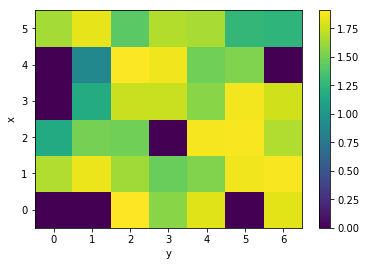

In [2]:
# Let's do a 2D array with a 3rd time axis and go for fits in that axis 
nt = 10                                # Ten elements in the time dimension
nx = 6                                 #     Six in the x
ny = 7                                 #     Seven in the y
images = np.ones([ny,nx,nt])           # A 3D numpy array of ones: Fast index is time (10), slow is y (7)
values = np.arange(0., nt*2., 2.)      # A list[] of floats 0., 2., ..., 18.
# print(values) gives us 0., 2., ..., 18.

noise = np.random.random([ny,nx,nt])   # A 3D numpy array of uniform random values on [0., 1.]
                                       #   which would be indexed via [a, b, c]; not [a][b][c]
# print(noise)

cubeStart = images*values              # A 3D numpy array where the fast index (time) goes 0, 1, ..., 9
                                       #   This uses 'broadcast multiplication' element-by-element along
                                       #   the fast (right-most) index. What if values[] has length nx or ny? 
                                       #   Answer: This is no good, won't work. The broadcast list must match 
                                       #   the fast index in length.
cubeNext = cubeStart + noise           # Element-by-element addition of the [0, 1] noise tensor
cube = cubeNext.T                      # .T is Transpose: Now the fast index is time, then follows x, then y

# print(cube.shape) gives (10,6,7)

nNans = 6*7*7
for i in range(nNans):
    i1 = ri(0, 9)
    i2 = ri(0, 5)
    i3 = ri(0, 6)
    cube[i1, i2, i3] = np.nan

# counter = np.zeros([6, 7])
# for i in range(7):
#     for j in range(6):
#         c = 0.
#         for k in range(10):
#             # print(cube[k,j,i]) prints values or occasional nans
#             if np.isnan(cube[k,j,i]): c += 1.
#         counter[j, i] = c
# print(counter)

dacube = xr.DataArray(cube, name='cubedata', coords=[('time', range(10)),('x',range(6)),('y',range(7))])

def _calc_slope(x, y):
    '''wrapper that returns the slop from a linear regression fit of x and y'''
    # return stats.linregress(x, y)[0]  # extract slope only
    # print(len(x), '     ', x, '    ', y)
    # print(x, y)
    idx = np.isfinite(y)
    # nFalse = np.size(idx) - np.count_nonzero(idx)
    if np.count_nonzero(idx) < 4: return 0.
    y_medianfilter = mf(y[idx], kernel_size=3); 
    return np.polyfit(x[idx], y_medianfilter, 1)[0]

def linear_trend(obj):
    # time_nums = xr.DataArray(obj['time'].values.astype(np.float),
    #                          dims='time',
    #                          coords={'time': obj['time']},
    #                          name='time_nums')
    trend = xr.apply_ufunc(_calc_slope, obj.time, obj,
                           vectorize=True,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')
    return trend

# lt = linear_trend(dacube.dropna('time'))
lt = linear_trend(dacube)
print(type(lt))
lt.plot()

2D Line plot methods or kwargs...

- axes
- draw
- figure
- lineStyles
- markers
- set_alpha
- set_color
- set_data
- set_drawstyle
- set_label
- set_ls
- set_lw
- set_marker
- set_markeredgecolor
- set_markeredgewidth
- set_markerfacecolor
- set_markersize
- set_visible
- set_xdata